<a href="https://colab.research.google.com/github/DiegoSnach/GLUE-Benchmark/blob/master/4_Quora_Siamese_model_Glove_qqc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from time import time
import datetime
import pandas as pd
import numpy as np
import re
import os
import itertools
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint

import tensorflow as tf 
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


GPU is available


In [2]:
# if `batch_size=-1`, will return the full dataset as `tf.tensor`s. ABSOLUTELY FUNDAMENTAL!

train_data, validation_data = tfds.load(name='glue/qqp', split=['train', 'validation'], batch_size=-1)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/glue/qqp/1.0.0.incompleteLCX0RK/glue-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/glue/qqp/1.0.0.incompleteLCX0RK/glue-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/glue/qqp/1.0.0.incompleteLCX0RK/glue-test.tfrecord


Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/qqp/1.0.0. Subsequent calls will reuse this data.


In [3]:
# check dataset

train_data.keys()

dict_keys(['idx', 'label', 'question1', 'question2'])

In [4]:
# Convert to dataFrame

df_train = pd.DataFrame(data=train_data)
df_validation = pd.DataFrame(data=validation_data)

In [5]:
df_validation.tail()

,idx,label,question1,question2
40425,32434,0,b'Are both UY Scuti and VY Canis Majoris the s...,b'What would UY Scuti look like if it were the...
40426,26967,1,b'What would be his reaction if I give him a a...,b'What would be his reaction if I give him a l...
40427,18713,1,b'I recently found my dad is cheating on my mo...,b'My dad is cheating on my mom. What should I ...
40428,19274,1,b'Is Jesus historically real?',b'Was Jesus real?'
40429,18576,0,b'Vaginaplasty: Who are the best surgeons in N...,"b""How can you look at someone's private Instag..."


In [6]:
# Creates function to clean data

def process_data (data):
  punct = "/-?!.,#$%\()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
  def clean_the_text (text, punt):
    for p in punct:
      text = text.replace(p, ' ')
      text = text.replace("b'", ' ', 1)
      text = text.replace('b"', ' ', 1)
    return text
  
  data =  data.astype(str).apply(lambda x: clean_the_text(x, punct))
  return data  

In [7]:
# Change the datatypes as they come as tensor object

question1 = process_data(df_train.question1.apply(str))
question2 = process_data(df_train.question2.apply(str))
label = df_train.label
print(len(question1))
print(len(question2))
print(len(label))

363849
363849
363849


In [8]:
# Check lenght of sentence

count = question1.apply(lambda x: len(str(x).split()))
print('Mean: %f' % (count.mean()))
print('Median: %f' % (count.median()))
print('Max: %f' % (count.max()))

Mean: 12.008204
Median: 11.000000
Max: 261.000000


In [9]:
# Count it for sentence 2

count2 = question2.apply(lambda x: len(str(x).split()))
print('Mean: %f' % (count2.mean()))
print('Median: %f' % (count2.median()))
print('Max: %f' % (count2.max()))

Mean: 12.245522
Median: 11.000000
Max: 341.000000


In [10]:
# Bring Keras tokenizer, builds vocabulary and pads sequences

Tokenizer = tf.keras.preprocessing.text.Tokenizer
pad_sequences = tf.keras.preprocessing.sequence.pad_sequences

tokenizer = Tokenizer(num_words=50000) # Takes the 50K most common tokens
max_len = 32 # Limit sentences to 20 words

# Creates vocabulary and gives number of tokens in corpus

tokenizer.fit_on_texts(list(question1) + list(question2))
vocab_size = len(tokenizer.word_index)+1 # Because starts counting at 0
print(vocab_size)

89574


In [11]:
# Converts sentences to sequences of integers
# post pad them to max set to 40 

encoded_quest1 = tokenizer.texts_to_sequences(question1)
padded_quest1 = pad_sequences(encoded_quest1, maxlen=max_len, padding='post')

encoded_quest2 = tokenizer.texts_to_sequences(question2)
padded_quest2 = pad_sequences(encoded_quest2, maxlen=max_len, padding='post')

# Check
print(question1[5])
print(encoded_quest1[5])
print(padded_quest1[5])

 What are the descriptive thesis titles related to civil engineering '
[3, 12, 2, 7819, 2737, 5735, 800, 8, 470, 133, 1]
[   3   12    2 7819 2737 5735  800    8  470  133    1    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


In [12]:
# We do the same for the validation set to check after training

val_question1 = process_data(df_validation.question1.apply(str))
val_question2 = process_data(df_validation.question2.apply(str))
val_label = df_validation.label
print(len(val_question1))
print(len(val_question2))
print(len(val_label))

40430
40430
40430


In [13]:
# Converts sentences to sequences of integers for VAL_SET
# post pad them to max set to 40 

val_encoded_quest1 = tokenizer.texts_to_sequences(val_question1)
val_padded_quest1 = pad_sequences(val_encoded_quest1, maxlen=max_len, padding='post')

val_encoded_quest2 = tokenizer.texts_to_sequences(val_question2)
val_padded_quest2 = pad_sequences(val_encoded_quest2, maxlen=max_len, padding='post')

# Check
print(val_question1[5])
print(val_encoded_quest1[5])
print(val_padded_quest1[5])

 What are the best aspects of living in P xc3 xa9sterion  Greece as a young adult '
[3, 12, 2, 19, 1646, 11, 447, 9, 1501, 423, 3790, 46, 7, 1105, 1387, 1]
[   3   12    2   19 1646   11  447    9 1501  423 3790   46    7 1105
 1387    1    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


In [14]:
# download pretrained GloVe embeddings

# !wget http://nlp.stanford.edu/data/glove.6B.zip

# !unzip glove.6B.zip

In [17]:
# Mount them from drive for quicker performance

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [18]:
# lists files

!ls "/content/gdrive/My Drive/Glove/glove.6B.100d.txt"

'/content/gdrive/My Drive/Glove/glove.6B.100d.txt'


In [19]:
# Creates dictionary of word embeddings

glove_dir = './'

embeddings_index = {} #initialize dictionary
f = open(os.path.join('/content/gdrive/My Drive/Glove/glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [20]:
# Matches words/tokens from vocabulary to their embeddings

embedding_dimensions = 100

embedding_matrix = np.zeros((vocab_size, embedding_dimensions))

for word, i in tokenizer.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector   

In [21]:
# Builds a dict for the two inputs of the Siamese LSTM

X_train = {'left': padded_quest1, 'right': padded_quest2}
Y_train = label

In [22]:
# Make sure everything is ok
# CHECK WHETHER THIS IS NEEDED OR IT CAN BE DIFFERENT LENGHT

assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

In [23]:
# Builds a dict for the two inputs of the Siamese LSTM at validation as well

X_val = {'left': val_padded_quest1, 'right': val_padded_quest2}
Y_val = val_label

In [24]:
# Make sure everything is ok
# CHECK WHETHER THIS IS NEEDED OR IT CAN BE DIFFERENT LENGHT

assert X_val['left'].shape == X_val['right'].shape
assert len(X_val['left']) == len(Y_val)

In [25]:
# Calculates Manhattan Distance as in Jonas Mueller 
# https://gist.github.com/GKarmakar/3aa0c643ddb0688a9bfc44b43b84edd8

def manhattan_distance(left,right):
  return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

In [26]:
# Starts building model Siamese LSTM

from tensorflow.python.keras.layers import Input, Embedding, LSTM, GRU, Conv1D, Conv2D, GlobalMaxPool1D, Dense, Dropout
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Layer

In [47]:
# Defines hidden dimensions of lstm and embedding
# From Jonas Mueller: The LSTM learns a mapping from the space of variable length 
# sequences of 300 dimensional vectors into 50 (100 D for us )

n_hidden = 50

embed = Embedding(vocab_size, embedding_dimensions, weights=[embedding_matrix],input_length=max_len, trainable=False)

In [48]:
# Defines LSTM_model and shows it

lstm_layer = Sequential()
lstm_layer.add(embed)
lstm_layer.add(LSTM(n_hidden, dropout=0.2))
#lstm_layer.add(Dense(1, activation='relu'))
lstm_layer.summary()

 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 100)           8957400   
_________________________________________________________________
lstm (LSTM)                  (None, 50)                30200     
Total params: 8,987,600
Trainable params: 30,200
Non-trainable params: 8,957,400
_________________________________________________________________


In [49]:
# Defines left and right inputs to the lstm
# Input has automatic shape inference

left_input = Input(shape=(max_len,), dtype='int32')
right_input = Input(shape=(max_len,), dtype='int32')

# Output of the lstm

left = lstm_layer(left_input)
right = lstm_layer(right_input)

In [50]:
# Calculates Manhattan Distance and instantiates the Model
# when training the model, the weights of the LSTM layer are updated based on both inputs

malstm_distance = manhattan_distance(left=left, right=right)
model = Model(inputs = [left_input, right_input], outputs = [malstm_distance])

In [51]:
# Compiles with loss MSE and Adadelta as in Jonas Mueller. Prints summary

model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 50)           8987600     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Sub (TensorFlowOpLa [(None, 50)]         0           sequential[1][0]             

In [52]:
# Early stopping to prevent under/over fitting

from tensorflow.keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=2, verbose=0, mode='auto')

In [53]:
# start training 
malstm_trained = model.fit([X_train['left'], X_train['right']], Y_train, 
                           batch_size=256,
                           epochs=10, 
                           verbose=True, 
                           validation_split=0.2,
                           callbacks=[earlystop])

Epoch 1/10
1138/1138 [==============================] - 11s 10ms/step - loss: 0.2005 - accuracy: 0.6842 - val_loss: 0.1911 - val_accuracy: 0.7092
Epoch 2/10
1138/1138 [==============================] - 10s 9ms/step - loss: 0.1812 - accuracy: 0.7234 - val_loss: 0.1745 - val_accuracy: 0.7414
Epoch 3/10
1138/1138 [==============================] - 10s 9ms/step - loss: 0.1728 - accuracy: 0.7399 - val_loss: 0.1648 - val_accuracy: 0.7592
Epoch 4/10
1138/1138 [==============================] - 10s 9ms/step - loss: 0.1678 - accuracy: 0.7496 - val_loss: 0.1711 - val_accuracy: 0.7494
Epoch 5/10
1138/1138 [==============================] - 10s 9ms/step - loss: 0.1642 - accuracy: 0.7564 - val_loss: 0.1606 - val_accuracy: 0.7664
Epoch 6/10
1138/1138 [==============================] - 10s 9ms/step - loss: 0.1608 - accuracy: 0.7635 - val_loss: 0.1587 - val_accuracy: 0.7706
Epoch 7/10
1138/1138 [==============================] - 11s 9ms/step - loss: 0.1587 - accuracy: 0.7669 - val_loss: 0.1540 - val_a

In [46]:
K.clear_session()

In [54]:
evaluation = model.evaluate([X_val['left'], X_val['right']], Y_val)
print(evaluation)

1264/1264 [==============================] - 5s 4ms/step - loss: 0.1579 - accuracy: 0.7727
[0.1578596979379654, 0.7727182507514954]


In [55]:
prediction = model.predict([X_val['left'],X_val['right']])
print(prediction)

[[0.20923208]
 [0.07007725]
 [0.12203345]
 ...
 [0.5518319 ]
 [0.6704072 ]
 [0.08766828]]


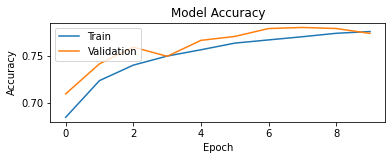

In [56]:
# Plot Accuracy

plt.subplot(211)
plt.plot(malstm_trained.history['accuracy'])
plt.plot(malstm_trained.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')

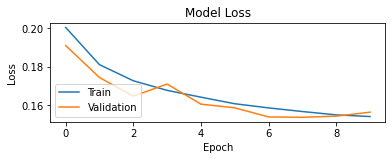

In [57]:
# Plot loss

plt.subplot(211)
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower left')